In [1]:
import sys
sys.path.insert(0,'..')

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import gym
from fakegym.fakegym import FakeGym
#import environment
import importlib
from fakegym import utils

In [2]:
#importlib.reload(environment)

class MyObservation():
    def __init__(self, env):
        self.env = env
        self.gps_actual = None
        self.gps_target = None
        self.distance = None
        self.touching = None

    def _update(self):
        self.gps_actual = self.env.state_object.gps_actual
        self.gps_target = self.env.state_object.gps_target
        self.distance = self.env.state_object.distance
        self.touching = self.env.state_object.touching

    def shape(self):
        """Make sure length is correct here.In this example:
        gps_actual: 2
        gps_target: 2
        distance:   4
        touching:   1
        =================
                   (9, )
        
        """
        return (9, )

    def get(self, env):
        """Get observation as numpy array."""
        self._update()
        
        arr = np.empty(0)
        arr = np.hstack((arr, np.array(self.gps_actual)))
        arr = np.hstack((arr, np.array(self.gps_target)))
        arr = np.hstack((arr, np.array(self.distance)))
        arr = np.hstack((arr, np.array(self.touching)))
        
        return arr
    

class MyEnv(FakeGym):
    def __init__(self, seed=None, N=10, num_of_sensors=4, obstacles_each=2,
                 step_range=(1, 1), action_type="discrete",
                 discrete_action_shaping="flatten", obs=MyObservation):
        super(MyEnv, self).__init__(seed, N, num_of_sensors, obstacles_each, step_range, action_type, discrete_action_shaping, obs)
        
    def get_target_distance(self,rx,ry):
        """Calculate euklidian distance to target."""
        return utils.euklidian_distance((rx,ry), self.gps_target)
    
    def distance_sensor(self,rx,ry):
        """Calculate distance to obstacles in all directions.

        Starts at 0 degrees and moves clockwise. The number and angle of
        directions is specified by num_of_sensors.
        """
        N = self.com.N
        pos = (rx,ry)
        endpoints = [(0, 0), (N - 1, 0), (0, N - 1), (N - 1, N - 1)]
        radius = round(max([utils.euklidian_distance(pos, ep) for
                            ep in endpoints]))
        phi = np.linspace(0, 2 * np.pi, self.com.num_of_sensors + 1)[:-1]
        pos = self.com.pos_outer
        y = (radius * np.cos(phi)).astype(int) + pos[1]
        x = (radius * np.sin(phi)).astype(int) + pos[0]
        anchors = list(zip(x, y))
        distances = []
        self.com.anchors = anchors
        for anch in anchors:
            distances.append(self.com.pts_to_anchor(anch)[1] - 1)
        self.com.state.distance = distances
        return anchors, distances

        
    def calc_reward(self,rx,ry):
        """
        !!!don't forget to transfer these methods!!!
        self.get_target_distance() ----> self.get_target_distance(rx,ry)
        self.com.distance_sensor()[1] ----> self.distance_sensor(rx,ry)[1]
        """

        """Calculate reward function.

        Idea(Mats):
        - negative reward for normal move so that james moves faster to goal
        - still lower negative reward if james gets closer to goal
        - high positive award for reaching it
        - high negative award to hitting a wall
        - epsilon only to divide never by 0

        """
        
        if self.gps_actual == self.gps_target:
            reward = 1000
        else:
            epsilon = 10**-5
            cost_step = 1
            distance = self.get_target_distance(rx,ry)+epsilon
            cost_distance = (distance**0.4)/(distance)
            reward_factor = 1
            reward = reward_factor * (cost_step * cost_distance)
            if self.state_object:
                reward = reward - 10
        return reward

        """Calculate reward function.

        For obstacle punishment we have consider three situation: 
        a) if the target area is too close to an obstacle, the obstalcle will
        give no negative reward, otherwise the robot might because of avoiding
        the collision and don't go to the target. 
        b) set a detection distance like you have discussed in our meeting, the
        obstacle punishment is from 0 to 1, so that the punishment will be 
        continius from 0 to 1 (1 means there are no distance from robot and 
        obstacle) 
        c) if the obstacle is far away from the robot(obst_dist > radius), 
        the punishment will be 0.

        """
#         if self.gps_actual == self.gps_target:
#             reward = 100
#         else:
#             #distance reward
#             epsilon = 10**-5
#             dist_max = np.sqrt(2)*self.com.N
#             dist_penalty = self.get_target_distance(rx,ry)+epsilon
#             dist_reward = (dist_penalty**0.4)/(dist_penalty)
#             #obstacle punishment
#             radius = 3
#             #if the target is too near to an obstacle
#             if self.get_target_distance(rx,ry) <= np.sqrt(2)*(radius+1):
#                 obstacle_reward = 0
#             else:
#                 obst_dist = np.min(self.distance_sensor(rx,ry)[1])
#                 if obst_dist <= np.sqrt(2)*radius:
#                     obstacle_reward = 1-((obst_dist-1)/(np.sqrt(2)*radius))
#                 else:
#                     obstacle_reward = 0
#             reward = dist_reward - obstacle_reward
#             #reward = dist_reward
#             #crash
#             if self.state_object.touching:
#                 reward =  reward- 10
#         return reward
    
        """Calculate reward function.

        cost_distance = np.tanh(dist_penalty/(max_distance/2))

        """
#         if self.gps_actual == self.gps_target:
#             reward = 1000
#         else:
#             epsilon = 10**-5
#             cost_step = 1
#             max_distance = np.sqrt(2)*self.com.N
#             dist_penalty = self.get_target_distance(rx,ry)+epsilon
#             #cost_distance = (distance**0.4)/(distance)
#             cost_distance = np.tanh(dist_penalty/(max_distance/2))
#             reward_factor = -1
#             reward = reward_factor * (cost_step * cost_distance)
#             if self.state_object:
#                 reward = reward - 10
#         return reward




In [3]:
WALLSIZE = 1.0
VAL_WALL = 1.0
VAL_OBSTACLE = 2.0
VAL_ROBBIE = 4.0
VAL_TARGET = 6.0

In [4]:
def reward_visualize(env):
    reward_field = env.com.field.copy()
    for rx in range(N):
        for ry in range(N):
            if((env.com.field[rx,ry]!=VAL_WALL)&(env.com.field[rx,ry]!=VAL_OBSTACLE)&((rx,ry)!=env.gps_target)):
                if((rx,ry)!=env.gps_target):
                    reward_field[rx][ry] = env.calc_reward(rx,ry)
            else:
                reward_field[rx][ry] = -float("inf")         

    r_max = reward_field.max()
    r_min = float("inf")
    for rx in range(N):
        for ry in range(N):
            if((reward_field[rx][ry]!=-float("inf"))&(reward_field[rx][ry]<r_min)):
                r_min = reward_field[rx][ry]
                
    for rx in range(env.com.N):
        for ry in range(env.com.N):
            if((reward_field[rx][ry]==-float("inf"))&((rx,ry)!=env.gps_target)):
                reward_field[rx][ry]=r_min
            elif ((rx,ry)==env.gps_target):
                reward_field[rx][ry]=r_max

    reward_field = (reward_field-r_min)/(r_max-r_min)
    
    #print(reward_field)
    return reward_field

def plot_2d(reward_field):
    plt.imshow(reward_field,cmap = 'jet')
    plt.colorbar()
    
def plot_3d(Z):
    %matplotlib notebook
    fig=plt.figure()
    ax=Axes3D(fig)
    
    X = np.linspace(0,N,N)
    Y = np.linspace(0,N,N)
    X, Y = np.meshgrid(X, Y)
    
    ax.plot_surface(X,Y,Z,rstride=1,cstride=1,cmap=plt.get_cmap('rainbow'))
    
    ax.set_zlim(0,1)

    plt.show()


<Figure size 720x720 with 0 Axes>

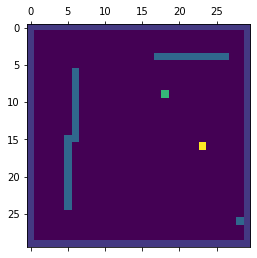

In [5]:
N = 30
env = MyEnv(N=N)
env.render()

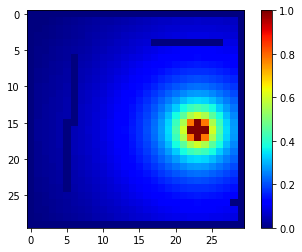

In [6]:
reward_field = reward_visualize(env)
plot_2d(reward_field)


<IPython.core.display.Javascript object>


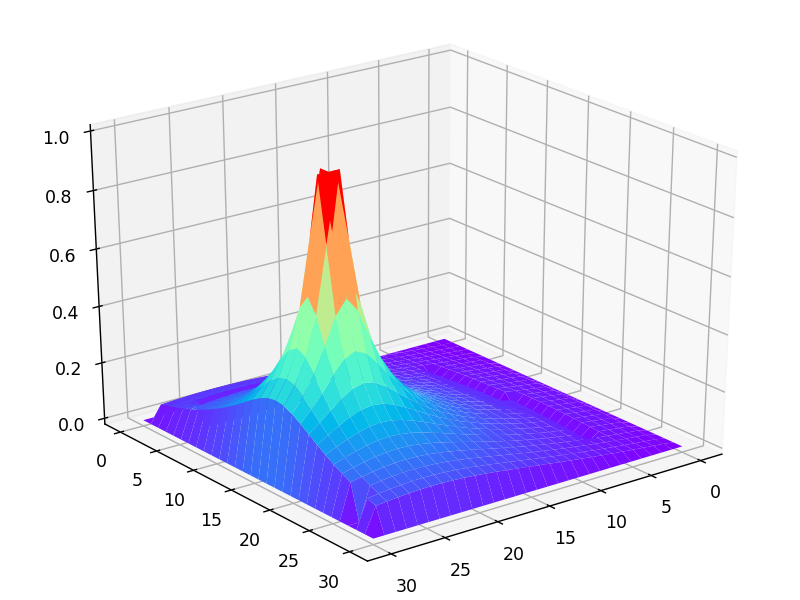

In [7]:
plot_3d(reward_field)